In [2]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 5.7 MB/s eta 0:00:00


In [24]:
import numpy as np
import pandas as pd
import tensorflow as tf
from numpy import concatenate
import optuna
import xgboost as xgb
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import load_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from tensorflow.keras.layers import Input
from sklearn.metrics import r2_score


In [4]:

file_path = "/content/Enhanced_Processed_Financial_Data.csv"

merged_df_cleaned = pd.read_csv(file_path)

print(merged_df_cleaned.head())


lag_steps = 1

def sequential_to_supervised(data, lag_steps=1, dropnan=True):
    df = pd.DataFrame(data)
    cols = [df.shift(i) for i in range(lag_steps, 0, -1)] + [df]
    agg = pd.concat(cols, axis=1)
    if dropnan:
        agg.dropna(inplace=True)
    return agg



   Unnamed: 0       BDI       CPI      EFFR       IPI  Unemployment  \
0          11 -0.644072  1.077695  0.259805 -0.981753      0.097132   
1          12 -0.644072  0.763882  0.089210 -1.015562      0.097132   
2          13 -0.644072  0.601610  0.102789 -1.009775      0.160665   
3          14 -0.644072  0.441023  0.226799 -0.787657      0.097132   
4          15 -0.644072  0.582020  0.348562 -0.617147      0.097132   

   CRB_Change  Fed_Assets_Change  PCE_Change  SP500_Change  USD_Index_Change  \
0   -0.151658           0.904350   -0.136684     -0.268744          0.008760   
1    1.391107          -0.740962    0.299657     -0.268744         -0.076836   
2   -0.358502          -0.867269    0.513742     -0.268744         -0.016110   
3    0.122169          -0.182015    0.862074     -0.268744          0.033875   
4   -0.575560          -2.232555    0.989300     -0.268744         -0.400897   

   CRB_MA_3  CRB_MA_6  CRB_MA_12  CRB_Lag_1  CRB_Lag_2  CRB_Lag_3  CRB_Lag_6  
0 -0.933123 -

In [5]:
print("Preparing features and target...")
features = merged_df_cleaned.drop(columns=["CRB_Change"])
target = merged_df_cleaned["CRB_Change"]

dataset = pd.concat([features, target], axis=1)
supervised_dataset = sequential_to_supervised(dataset, lag_steps)


cols_at_end = ["CRB_Change"]
supervised_dataset = supervised_dataset[[c for c in supervised_dataset if c not in cols_at_end] + cols_at_end]

print(supervised_dataset.head())


scaler = MinMaxScaler(feature_range=(0, 1))
supervised_scaled = scaler.fit_transform(supervised_dataset)



split = int(supervised_scaled.shape[0] * 0.8)
train, test = supervised_scaled[:split, :], supervised_scaled[split:, :]



train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]



train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))


Preparing features and target...
   Unnamed: 0  Unnamed: 0       BDI       BDI       CPI       CPI      EFFR  \
1        11.0          12 -0.644072 -0.644072  1.077695  0.763882  0.259805   
2        12.0          13 -0.644072 -0.644072  0.763882  0.601610  0.089210   
3        13.0          14 -0.644072 -0.644072  0.601610  0.441023  0.102789   
4        14.0          15 -0.644072 -0.644072  0.441023  0.582020  0.226799   
5        15.0          16 -0.644072 -0.644072  0.582020  0.569129  0.348562   

       EFFR       IPI       IPI  ...  CRB_Lag_1  CRB_Lag_1  CRB_Lag_2  \
1  0.089210 -0.981753 -1.015562  ...  -1.055348  -0.104648  -0.908097   
2  0.102789 -1.015562 -1.009775  ...  -0.104648   1.446332  -1.046795   
3  0.226799 -1.009775 -0.787657  ...   1.446332  -0.312593  -0.107112   
4  0.348562 -0.787657 -0.617147  ...  -0.312593   0.170637   1.425896   
5  0.406993 -0.617147 -0.412523  ...   0.170637  -0.530807  -0.312647   

   CRB_Lag_2  CRB_Lag_3  CRB_Lag_3  CRB_Lag_6  CRB_La

# Optuna + LSTM

In [6]:
!pip install optuna xgboost prophet

In [7]:
split_val = int(train_X.shape[0] * 0.85)
val_X, train_X = train_X[split_val:], train_X[:split_val]
val_y, train_y = train_y[split_val:], train_y[:split_val]


In [8]:
def objective(trial):
    n_lstm_1 = trial.suggest_int("n_lstm_1", 32, 128)
    n_lstm_2 = trial.suggest_int("n_lstm_2", 16, 64)
    dropout_rate = trial.suggest_float("dropout", 0.15, 0.35)
    l2_reg = trial.suggest_float("l2_reg", 1e-5, 1e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)

    model = Sequential()
    model.add(LSTM(n_lstm_1, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2]),
                   kernel_regularizer=l2(l2_reg), recurrent_dropout=dropout_rate))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    model.add(LSTM(n_lstm_2, return_sequences=False, dropout=dropout_rate))
    model.add(BatchNormalization())

    model.add(Dense(1, kernel_regularizer=l2(l2_reg)))

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, clipvalue=1.0)
    model.compile(loss="mae", optimizer=optimizer)

    early_stopping = EarlyStopping(monitor="val_loss", patience=7, min_delta=0.0005, restore_best_weights=True)
    lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)

    model.fit(train_X, train_y, epochs=70, batch_size=batch_size,
              validation_data=(val_X, val_y), verbose=0, shuffle=False,
              callbacks=[early_stopping, lr_scheduler])

    yhat = model.predict(test_X)
    inv_yhat = scaler.inverse_transform(np.concatenate((test_X.reshape(test_X.shape[0], -1), yhat), axis=1))[:, -1]
    inv_y = scaler.inverse_transform(np.concatenate((test_X.reshape(test_X.shape[0], -1), test_y.reshape(-1, 1)), axis=1))[:, -1]

    rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
    return rmse


In [9]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=40)


[I 2025-02-24 04:26:59,032] A new study created in memory with name: no-name-7e884ac8-58d5-4085-8c3e-99b89e862b50
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step


[I 2025-02-24 04:27:16,518] Trial 0 finished with value: 1.182127079008111 and parameters: {'n_lstm_1': 90, 'n_lstm_2': 32, 'dropout': 0.1708452618616415, 'l2_reg': 0.0001422493466029634, 'batch_size': 32, 'learning_rate': 0.000511580739390343}. Best is trial 0 with value: 1.182127079008111.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step


[I 2025-02-24 04:27:28,736] Trial 1 finished with value: 1.1570043239729426 and parameters: {'n_lstm_1': 76, 'n_lstm_2': 38, 'dropout': 0.16733427552680966, 'l2_reg': 0.0006351147728618971, 'batch_size': 32, 'learning_rate': 0.0004981919413828248}. Best is trial 1 with value: 1.1570043239729426.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/3 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step


[I 2025-02-24 04:27:40,053] Trial 2 finished with value: 1.1810716493657387 and parameters: {'n_lstm_1': 54, 'n_lstm_2': 43, 'dropout': 0.15915918443718877, 'l2_reg': 0.00015474670301786916, 'batch_size': 64, 'learning_rate': 0.0008607068013074754}. Best is trial 1 with value: 1.1570043239729426.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step


[I 2025-02-24 04:27:50,765] Trial 3 finished with value: 1.1280670363358782 and parameters: {'n_lstm_1': 33, 'n_lstm_2': 27, 'dropout': 0.3230527547106705, 'l2_reg': 4.241967742112023e-05, 'batch_size': 32, 'learning_rate': 0.0020389031435171126}. Best is trial 3 with value: 1.1280670363358782.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 291ms/step


[I 2025-02-24 04:28:02,214] Trial 4 finished with value: 1.205538734640919 and parameters: {'n_lstm_1': 40, 'n_lstm_2': 21, 'dropout': 0.19007671949749733, 'l2_reg': 9.111208226748265e-05, 'batch_size': 32, 'learning_rate': 0.0014213835119093398}. Best is trial 3 with value: 1.1280670363358782.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 299ms/step


[I 2025-02-24 04:28:20,173] Trial 5 finished with value: 1.058117408256878 and parameters: {'n_lstm_1': 116, 'n_lstm_2': 57, 'dropout': 0.328666023568997, 'l2_reg': 8.709279748613065e-05, 'batch_size': 16, 'learning_rate': 0.00024841476730124557}. Best is trial 5 with value: 1.058117408256878.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 587ms/step


[I 2025-02-24 04:28:33,550] Trial 6 finished with value: 1.0292460758571025 and parameters: {'n_lstm_1': 116, 'n_lstm_2': 35, 'dropout': 0.19758441070972138, 'l2_reg': 8.801838599482825e-05, 'batch_size': 16, 'learning_rate': 0.0093603459166868}. Best is trial 6 with value: 1.0292460758571025.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 275ms/step


[I 2025-02-24 04:28:46,772] Trial 7 finished with value: 1.1996801338294767 and parameters: {'n_lstm_1': 69, 'n_lstm_2': 58, 'dropout': 0.15835865553024514, 'l2_reg': 3.262759539603572e-05, 'batch_size': 64, 'learning_rate': 0.0006182698852907954}. Best is trial 6 with value: 1.0292460758571025.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step


[I 2025-02-24 04:28:59,692] Trial 8 finished with value: 1.0355088161022163 and parameters: {'n_lstm_1': 94, 'n_lstm_2': 49, 'dropout': 0.19595802884155525, 'l2_reg': 7.774382697036325e-05, 'batch_size': 16, 'learning_rate': 0.001942925024581943}. Best is trial 6 with value: 1.0292460758571025.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step


[I 2025-02-24 04:29:10,532] Trial 9 finished with value: 1.3571263327540188 and parameters: {'n_lstm_1': 107, 'n_lstm_2': 24, 'dropout': 0.3285732888772579, 'l2_reg': 0.000681301728522717, 'batch_size': 64, 'learning_rate': 0.006870830733329317}. Best is trial 6 with value: 1.0292460758571025.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step


[I 2025-02-24 04:29:22,967] Trial 10 finished with value: 1.0614589350695793 and parameters: {'n_lstm_1': 127, 'n_lstm_2': 17, 'dropout': 0.24805988718288238, 'l2_reg': 1.4790271291904833e-05, 'batch_size': 16, 'learning_rate': 0.009391493207552715}. Best is trial 6 with value: 1.0292460758571025.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 361ms/step


[I 2025-02-24 04:29:36,917] Trial 11 finished with value: 1.2753254437807184 and parameters: {'n_lstm_1': 97, 'n_lstm_2': 48, 'dropout': 0.21804712339379567, 'l2_reg': 0.0002827757833389531, 'batch_size': 16, 'learning_rate': 0.00289703776536669}. Best is trial 6 with value: 1.0292460758571025.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step


[I 2025-02-24 04:29:48,597] Trial 12 finished with value: 1.1531487600208483 and parameters: {'n_lstm_1': 107, 'n_lstm_2': 49, 'dropout': 0.21534910187653272, 'l2_reg': 4.093429756620232e-05, 'batch_size': 16, 'learning_rate': 0.00448484540079218}. Best is trial 6 with value: 1.0292460758571025.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 317ms/step


[I 2025-02-24 04:30:01,874] Trial 13 finished with value: 1.0941514562420698 and parameters: {'n_lstm_1': 88, 'n_lstm_2': 64, 'dropout': 0.2635486308705681, 'l2_reg': 0.0002932912108306814, 'batch_size': 16, 'learning_rate': 0.004218893686169333}. Best is trial 6 with value: 1.0292460758571025.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step


[I 2025-02-24 04:30:19,274] Trial 14 finished with value: 1.4672837509934644 and parameters: {'n_lstm_1': 128, 'n_lstm_2': 36, 'dropout': 0.2131883529840833, 'l2_reg': 1.722362159140604e-05, 'batch_size': 16, 'learning_rate': 0.0001523004247906022}. Best is trial 6 with value: 1.0292460758571025.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step


[I 2025-02-24 04:30:30,958] Trial 15 finished with value: 1.2761693003234198 and parameters: {'n_lstm_1': 108, 'n_lstm_2': 45, 'dropout': 0.2580790766150686, 'l2_reg': 6.62012516629469e-05, 'batch_size': 16, 'learning_rate': 0.0016176542781045618}. Best is trial 6 with value: 1.0292460758571025.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step


[I 2025-02-24 04:30:42,282] Trial 16 finished with value: 1.1422812902909927 and parameters: {'n_lstm_1': 64, 'n_lstm_2': 53, 'dropout': 0.19650801084352512, 'l2_reg': 0.00021312100794956457, 'batch_size': 16, 'learning_rate': 0.0049019116808594184}. Best is trial 6 with value: 1.0292460758571025.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 863ms/step


[I 2025-02-24 04:30:55,966] Trial 17 finished with value: 1.0643389589514662 and parameters: {'n_lstm_1': 96, 'n_lstm_2': 30, 'dropout': 0.28610243929340606, 'l2_reg': 2.4881790912923456e-05, 'batch_size': 16, 'learning_rate': 0.0028872663873740364}. Best is trial 6 with value: 1.0292460758571025.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step


[I 2025-02-24 04:31:09,112] Trial 18 finished with value: 1.1775933258093938 and parameters: {'n_lstm_1': 115, 'n_lstm_2': 40, 'dropout': 0.23490696698738867, 'l2_reg': 1.008050399758187e-05, 'batch_size': 16, 'learning_rate': 0.009711774253368216}. Best is trial 6 with value: 1.0292460758571025.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step


[I 2025-02-24 04:31:24,220] Trial 19 finished with value: 1.180634824186584 and parameters: {'n_lstm_1': 82, 'n_lstm_2': 34, 'dropout': 0.18706491981174653, 'l2_reg': 5.920145085408419e-05, 'batch_size': 64, 'learning_rate': 0.0002713761993679162}. Best is trial 6 with value: 1.0292460758571025.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 269ms/step


[I 2025-02-24 04:31:36,448] Trial 20 finished with value: 1.1240225137692366 and parameters: {'n_lstm_1': 117, 'n_lstm_2': 52, 'dropout': 0.28624758755703966, 'l2_reg': 0.00044211560533143665, 'batch_size': 16, 'learning_rate': 0.0009648325722966057}. Best is trial 6 with value: 1.0292460758571025.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 337ms/step


[I 2025-02-24 04:31:52,317] Trial 21 finished with value: 1.065162877175821 and parameters: {'n_lstm_1': 118, 'n_lstm_2': 56, 'dropout': 0.3453028488373966, 'l2_reg': 0.00011333505462325511, 'batch_size': 16, 'learning_rate': 0.00013124841391410125}. Best is trial 6 with value: 1.0292460758571025.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 293ms/step


[I 2025-02-24 04:32:07,350] Trial 22 finished with value: 1.1633524842623106 and parameters: {'n_lstm_1': 100, 'n_lstm_2': 62, 'dropout': 0.2841840862308218, 'l2_reg': 6.951294282375377e-05, 'batch_size': 16, 'learning_rate': 0.0003385267194548544}. Best is trial 6 with value: 1.0292460758571025.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 300ms/step


[I 2025-02-24 04:32:22,448] Trial 23 finished with value: 1.1242082963985818 and parameters: {'n_lstm_1': 118, 'n_lstm_2': 59, 'dropout': 0.3072238210412823, 'l2_reg': 8.972192284788531e-05, 'batch_size': 16, 'learning_rate': 0.0002742073562221806}. Best is trial 6 with value: 1.0292460758571025.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step


[I 2025-02-24 04:32:38,117] Trial 24 finished with value: 1.044239096830421 and parameters: {'n_lstm_1': 104, 'n_lstm_2': 44, 'dropout': 0.2298215172646386, 'l2_reg': 0.00016736307381278248, 'batch_size': 16, 'learning_rate': 0.0001828698820824161}. Best is trial 6 with value: 1.0292460758571025.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step


[I 2025-02-24 04:32:49,485] Trial 25 finished with value: 1.1676253540885255 and parameters: {'n_lstm_1': 104, 'n_lstm_2': 43, 'dropout': 0.23165361786857178, 'l2_reg': 0.00018802816183280296, 'batch_size': 16, 'learning_rate': 0.0025681382758571745}. Best is trial 6 with value: 1.0292460758571025.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 275ms/step


[I 2025-02-24 04:33:00,844] Trial 26 finished with value: 1.2106991118918322 and parameters: {'n_lstm_1': 88, 'n_lstm_2': 47, 'dropout': 0.20092034672610407, 'l2_reg': 0.00034306745139777014, 'batch_size': 16, 'learning_rate': 0.0012979662249309064}. Best is trial 6 with value: 1.0292460758571025.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step


[I 2025-02-24 04:33:17,118] Trial 27 finished with value: 1.1603225217237565 and parameters: {'n_lstm_1': 79, 'n_lstm_2': 41, 'dropout': 0.18040559691218247, 'l2_reg': 0.00012136398002235718, 'batch_size': 16, 'learning_rate': 0.000105146527920437}. Best is trial 6 with value: 1.0292460758571025.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 297ms/step


[I 2025-02-24 04:33:39,539] Trial 28 finished with value: 0.6123025770743598 and parameters: {'n_lstm_1': 93, 'n_lstm_2': 29, 'dropout': 0.23309504650429083, 'l2_reg': 0.0009460676475652553, 'batch_size': 32, 'learning_rate': 0.005867038589875963}. Best is trial 28 with value: 0.6123025770743598.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 366ms/step


[I 2025-02-24 04:33:50,605] Trial 29 finished with value: 1.2233179851666338 and parameters: {'n_lstm_1': 91, 'n_lstm_2': 32, 'dropout': 0.20165321284617116, 'l2_reg': 0.0008212636879121162, 'batch_size': 32, 'learning_rate': 0.006412083434783081}. Best is trial 28 with value: 0.6123025770743598.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step


[I 2025-02-24 04:34:02,262] Trial 30 finished with value: 1.2228011571575226 and parameters: {'n_lstm_1': 63, 'n_lstm_2': 30, 'dropout': 0.17433049178330834, 'l2_reg': 0.0004645343708303114, 'batch_size': 32, 'learning_rate': 0.0065738630591986764}. Best is trial 28 with value: 0.6123025770743598.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step


[I 2025-02-24 04:34:14,810] Trial 31 finished with value: 1.0426869104083585 and parameters: {'n_lstm_1': 93, 'n_lstm_2': 36, 'dropout': 0.23226838145859596, 'l2_reg': 0.000978079339211708, 'batch_size': 32, 'learning_rate': 0.0034449296616151045}. Best is trial 28 with value: 0.6123025770743598.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step


[I 2025-02-24 04:34:27,418] Trial 32 finished with value: 1.1149480413033395 and parameters: {'n_lstm_1': 85, 'n_lstm_2': 37, 'dropout': 0.244080795790212, 'l2_reg': 0.0009496072907879121, 'batch_size': 32, 'learning_rate': 0.0038301378484297747}. Best is trial 28 with value: 0.6123025770743598.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step


[I 2025-02-24 04:34:38,389] Trial 33 finished with value: 1.208814090341006 and parameters: {'n_lstm_1': 77, 'n_lstm_2': 26, 'dropout': 0.21086066404655518, 'l2_reg': 0.0005965301401213085, 'batch_size': 32, 'learning_rate': 0.0020964205979111077}. Best is trial 28 with value: 0.6123025770743598.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step


[I 2025-02-24 04:34:50,011] Trial 34 finished with value: 1.206319461919441 and parameters: {'n_lstm_1': 94, 'n_lstm_2': 34, 'dropout': 0.22511261797634288, 'l2_reg': 0.00044271904184121826, 'batch_size': 32, 'learning_rate': 0.0034592186020895787}. Best is trial 28 with value: 0.6123025770743598.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step


[I 2025-02-24 04:35:03,865] Trial 35 finished with value: 1.3852449111084175 and parameters: {'n_lstm_1': 74, 'n_lstm_2': 38, 'dropout': 0.2727415202491954, 'l2_reg': 0.00023295345768596556, 'batch_size': 32, 'learning_rate': 0.005635373222240123}. Best is trial 28 with value: 0.6123025770743598.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step


[I 2025-02-24 04:35:14,819] Trial 36 finished with value: 1.2512257683664796 and parameters: {'n_lstm_1': 99, 'n_lstm_2': 28, 'dropout': 0.17055886639953638, 'l2_reg': 0.0007132345341281753, 'batch_size': 32, 'learning_rate': 0.00792774029904769}. Best is trial 28 with value: 0.6123025770743598.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step


[I 2025-02-24 04:35:25,799] Trial 37 finished with value: 1.0682444450908763 and parameters: {'n_lstm_1': 50, 'n_lstm_2': 40, 'dropout': 0.15476011510756188, 'l2_reg': 5.2107182603881324e-05, 'batch_size': 32, 'learning_rate': 0.0019844616944699133}. Best is trial 28 with value: 0.6123025770743598.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step


[I 2025-02-24 04:35:38,794] Trial 38 finished with value: 1.161606176334242 and parameters: {'n_lstm_1': 110, 'n_lstm_2': 25, 'dropout': 0.188428958995177, 'l2_reg': 0.00013844863453865412, 'batch_size': 64, 'learning_rate': 0.0006856967957126489}. Best is trial 28 with value: 0.6123025770743598.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 384ms/step


[I 2025-02-24 04:35:49,899] Trial 39 finished with value: 1.1823259020329902 and parameters: {'n_lstm_1': 72, 'n_lstm_2': 22, 'dropout': 0.23845226096149552, 'l2_reg': 3.551946883567252e-05, 'batch_size': 32, 'learning_rate': 0.005273357612564401}. Best is trial 28 with value: 0.6123025770743598.


In [11]:
print("Best hyperparameters found by Optuna:")
print(study.best_params)


Best hyperparameters found by Optuna:
{'n_lstm_1': 93, 'n_lstm_2': 29, 'dropout': 0.23309504650429083, 'l2_reg': 0.0009460676475652553, 'batch_size': 32, 'learning_rate': 0.005867038589875963}


In [20]:
best_params = study.best_params

best_lstm = Sequential([
    Input(shape=(train_X.shape[1], train_X.shape[2])),
    LSTM(best_params['n_lstm_1'], return_sequences=True,
         kernel_regularizer=l2(best_params['l2_reg']),
         recurrent_dropout=best_params['dropout']),
    BatchNormalization(),
    Dropout(best_params['dropout']),
    LSTM(best_params['n_lstm_2'], dropout=best_params['dropout']),
    BatchNormalization(),
    Dense(1, kernel_regularizer=l2(best_params['l2_reg']))
])

best_lstm.compile(loss="mae", optimizer=tf.keras.optimizers.Adam(
    learning_rate=best_params['learning_rate'], clipvalue=1.0))

early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6)

best_lstm.fit(train_X, train_y, epochs=100, batch_size=best_params['batch_size'],
              validation_data=(val_X, val_y), verbose=1, shuffle=False,
              callbacks=[early_stopping, lr_scheduler])


import os
model_dir = "models"
os.makedirs(model_dir, exist_ok=True)
best_lstm.save(os.path.join(model_dir, "best_lstm_model.h5"))


Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 112ms/step - loss: 1.2800 - val_loss: 0.2732 - learning_rate: 0.0059
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6438 - val_loss: 0.2527 - learning_rate: 0.0059
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.5032 - val_loss: 0.2785 - learning_rate: 0.0059
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3851 - val_loss: 0.2639 - learning_rate: 0.0059
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3019 - val_loss: 0.2387 - learning_rate: 0.0059
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3019 - val_loss: 0.2422 - learning_rate: 0.0059
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2963 - val_loss: 0.2784 - learning_rate: 0.0059
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2317 - val_loss: 0.2402 - learning_rate: 0.0059
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2251 - val_loss: 0.2342 - learning_rate: 0.0059
Epoch 10/100
9/9 ━━━━━━━━━━

In [ ]:
# LSTM predictions
lstm_pred = best_lstm.predict(test_X)
inv_lstm_pred = scaler.inverse_transform(
    np.concatenate((test_X.reshape(test_X.shape[0], -1), lstm_pred), axis=1)
)[:, -1]

inv_y = scaler.inverse_transform(
    np.concatenate((test_X.reshape(test_X.shape[0], -1), test_y.reshape(-1, 1)), axis=1)
)[:, -1]

rmse_lstm = np.sqrt(mean_squared_error(inv_y, inv_lstm_pred))
r2_lstm = r2_score(inv_y, inv_lstm_pred)

print(f"LSTM Test RMSE: {rmse_lstm:.5f}")
print(f"LSTM Test R²: {r2_lstm:.4f}")


In [13]:
from tensorflow.keras.models import load_model

model.save("best_lstm_model.h5")
print("LSTM model saved successfully!")


# loaded_model = load_model("best_lstm_model.h5")


NameError: name 'model' is not defined

In [ ]:

xgb_model = xgb.XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1)
xgb_model.fit(train_X.reshape(train_X.shape[0], -1), train_y)
xgb_pred_scaled = xgb_model.predict(test_X.reshape(test_X.shape[0], -1))

inv_xgb_pred = scaler.inverse_transform(
    np.concatenate((test_X.reshape(test_X.shape[0], -1), xgb_pred_scaled.reshape(-1, 1)), axis=1)
)[:, -1]

rmse_xgb = np.sqrt(mean_squared_error(inv_y, inv_xgb_pred))
r2_xgb = r2_score(inv_y, inv_xgb_pred)
print(f"XGBoost Test RMSE: {rmse_xgb:.5f}")
print(f"XGBoost Test R²: {r2_xgb:.4f}")


ols_model = sm.OLS(train_y, sm.add_constant(train_X.reshape(train_X.shape[0], -1))).fit()
ols_pred_scaled = ols_model.predict(sm.add_constant(test_X.reshape(test_X.shape[0], -1)))

inv_ols_pred = scaler.inverse_transform(
    np.concatenate((test_X.reshape(test_X.shape[0], -1), ols_pred_scaled.reshape(-1, 1)), axis=1)
)[:, -1]

rmse_ols = np.sqrt(mean_squared_error(inv_y, inv_ols_pred))
r2_ols = r2_score(inv_y, inv_ols_pred)
print(f"OLS Test RMSE: {rmse_ols:.5f}")
print(f"OLS Test R²: {r2_ols:.4f}")

comparison_df = pd.DataFrame({
    "Model": ["LSTM", "XGBoost", "OLS"],
    "RMSE": [rmse_lstm, rmse_xgb, rmse_ols],
    "R² Score": [r2_lstm, r2_xgb, r2_ols]
})

print("\nModel Performance Comparison:")
print(comparison_df)

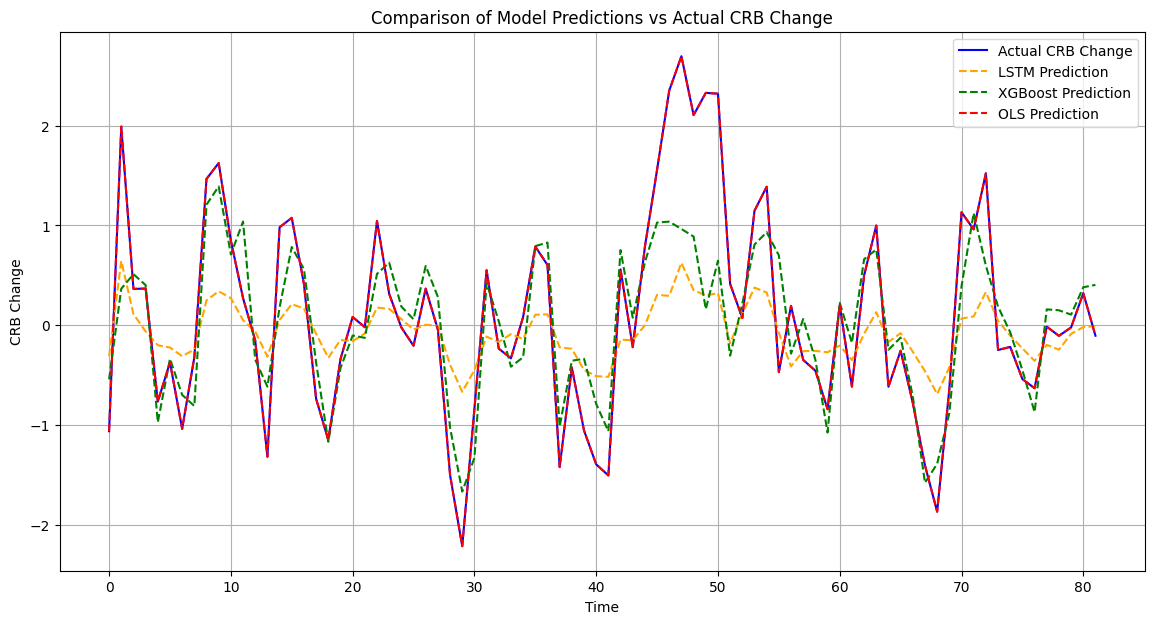

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(inv_y, label='Actual CRB Change', color='blue')
plt.plot(inv_lstm_pred, label='LSTM Prediction', linestyle='dashed', color='orange')
plt.plot(inv_xgb_pred, label='XGBoost Prediction', linestyle='dashed', color='green')
plt.plot(inv_ols_pred, label='OLS Prediction', linestyle='dashed', color='red')

plt.legend()
plt.xlabel("Time")
plt.ylabel("CRB Change")
plt.title("Comparison of Model Predictions vs Actual CRB Change")
plt.grid(True)
plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


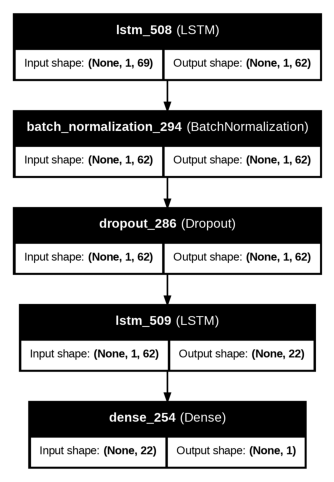

In [ ]:
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
from PIL import Image

best_params = study.best_params

model = Sequential()
model.add(LSTM(best_params["n_lstm_1"], return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2]),
               kernel_regularizer=l2(best_params["l2_reg"]), recurrent_dropout=best_params["dropout"]))
model.add(BatchNormalization())
model.add(Dropout(best_params["dropout"]))
model.add(LSTM(best_params["n_lstm_2"], return_sequences=False, dropout=best_params["dropout"]))
model.add(Dense(1, kernel_regularizer=l2(best_params["l2_reg"])))


plot_model(model, to_file="lstm_architecture.png", show_shapes=True, show_layer_names=True)

img = Image.open("lstm_architecture.png")
plt.figure(figsize=(10, 6))
plt.imshow(img)
plt.axis('off')
plt.show()
